In [23]:
import random
import numpy as np
from collections import deque
from rdkit import Chem
from rdkit.Chem import QED, Crippen, AllChem
import torch
import torch.nn as nn
from rdkit.Chem import Descriptors
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from rdkit.Chem import Draw
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML

In [25]:
# Molecule building blocks
fragments = [
    '[*]C',         # methyl
    '[*]CC',        # ethyl
    '[*]N',         # amine
    '[*]O',         # hydroxyl
    '[*]c1ccccc1',  # phenyl
    '[*]C(=O)O'     # carboxylic acid
]

In [26]:
reaction_smarts = '[*:1].[*:2]>>[*:1][*:2]'
rxn = AllChem.ReactionFromSmarts(reaction_smarts)

base_state = 'C[*]'

In [27]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)

In [28]:
def encode_smiles(smiles, max_len=64):
    vec = [ord(c) for c in smiles[:max_len]]
    return np.array(vec + [0] * (max_len - len(vec)), dtype=np.float32)

In [29]:
def penalized_logp(mol):
    log_p = Crippen.MolLogP(mol)
    qed_score = QED.qed(mol)
    return log_p + qed_score

    # Lipinski's Rule of 5 check
    if mol_wt > 500 or log_p > 5 or h_donors > 5 or h_acceptors > 10:
        penalty = -2.0  # Apply penalty for rule violation
    else:
        penalty = 0.0

    return qed_score + log_p + penalty

### Environment DrugMDP

In [30]:
class DrugMDP:
    def __init__(self, max_steps=10):
        self.max_steps = max_steps
        self.reset()

    def reset(self):
        self.smiles = base_state
        self.steps = 0
        return self.get_state()

    def get_state(self):
        return encode_smiles(self.smiles)

    def get_action_space(self):
        return list(range(len(fragments)))

    def apply_fragment(self, base_smiles, frag_smiles):
        try:
            mol1 = Chem.MolFromSmiles(base_smiles)
            mol2 = Chem.MolFromSmiles(frag_smiles)
            if mol1 is None or mol2 is None:
                return None
            products = rxn.RunReactants((mol1, mol2))
            if not products:
                return None
            newmol = products[0][0]
            Chem.SanitizeMol(newmol)
            return Chem.MolToSmiles(newmol)
        except:
            return None

    def step(self, action):
        frag = fragments[action]
        next_smiles = self.apply_fragment(self.smiles, frag)

        if next_smiles is None:
            return self.get_state(), -1.0, True

        try:
            mol = Chem.MolFromSmiles(next_smiles)
            Chem.SanitizeMol(mol)
        except:
            return self.get_state(), -1.0, True

        self.smiles = next_smiles
        self.steps += 1
        reward = penalized_logp(mol)
        done = self.steps >= self.max_steps
        return self.get_state(), reward, done

In [31]:
num_episodes = 300
batch_size = 64
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995
target_update_freq = 10

In [32]:
env = DrugMDP(max_steps=10)
state_size = 64
action_size = len(fragments)

policy_net = DQN(state_size, action_size)
target_net = DQN(state_size, action_size)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
replay_buffer = ReplayBuffer()
episode_rewards = []
top_molecules = []
animation_smiles = []
animation_episode = 50

In [36]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return (np.array(states), actions, rewards, np.array(next_states), dones)

    def __len__(self):
        return len(self.buffer)

In [37]:
def select_action(model, state, epsilon, action_size):
    if random.random() < epsilon:
        return random.randint(0, action_size - 1)
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        q_values = model(state_tensor)
    return torch.argmax(q_values).item()

for episode in tqdm(range(1, num_episodes + 1), desc="Training Episodes"):
    print(f"Running Episode {episode}")
    state = env.reset()
    total_reward = 0

    for _ in range(env.max_steps):
        action = select_action(policy_net, state, epsilon, action_size)
        next_state, reward, done = env.step(action)

        if episode == animation_episode:
            mol = Chem.MolFromSmiles(env.smiles)
            animation_smiles.append(mol)

        replay_buffer.push(state, action, reward, next_state, done)
        top_molecules.append((reward, Chem.MolFromSmiles(env.smiles)))
        top_molecules = sorted(top_molecules, key=lambda x: x[0], reverse=True)[:5]

        state = next_state
        total_reward += reward
        if done:
            break

        if len(replay_buffer) >= batch_size:
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

            states_tensor = torch.tensor(states, dtype=torch.float32)
            actions_tensor = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
            rewards_tensor = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
            next_states_tensor = torch.tensor(next_states, dtype=torch.float32)
            dones_tensor = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

            current_q = policy_net(states_tensor).gather(1, actions_tensor)
            max_next_q = target_net(next_states_tensor).max(1)[0].detach().unsqueeze(1)
            expected_q = rewards_tensor + (gamma * max_next_q * (1 - dones_tensor))

            loss = nn.MSELoss()(current_q, expected_q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    if episode % target_update_freq == 0:
        target_net.load_state_dict(policy_net.state_dict())

    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    episode_rewards.append(total_reward)
    if episode % 10 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}")


Training Episodes:   1%|          | 2/300 [00:00<00:22, 13.15it/s]

Running Episode 1
Running Episode 2
Running Episode 3


Training Episodes:   1%|▏         | 4/300 [00:00<00:23, 12.44it/s]

Running Episode 4
Running Episode 5


[10:05:17] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:   2%|▏         | 6/300 [00:00<00:29,  9.89it/s]

Running Episode 6
Running Episode 7


Training Episodes:   3%|▎         | 8/300 [00:00<00:36,  7.96it/s]

Running Episode 8
Running Episode 9


Training Episodes:   3%|▎         | 9/300 [00:01<00:35,  8.18it/s][10:05:17] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:17] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:17] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:17] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:   4%|▍         | 13/300 [00:01<00:22, 12.74it/s]

Running Episode 10
Episode 10, Total Reward: 0.77, Epsilon: 0.951
Running Episode 11
Running Episode 12
Running Episode 13
Running Episode 14


[10:05:18] Explicit valence for atom # 0 O, 3, is greater than permitted


Running Episode 15


Training Episodes:   5%|▌         | 15/300 [00:01<00:29,  9.59it/s][10:05:18] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:18] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:   6%|▌         | 17/300 [00:01<00:25, 10.99it/s]

Running Episode 16
Running Episode 17
Running Episode 18


Training Episodes:   6%|▋         | 19/300 [00:01<00:24, 11.27it/s][10:05:18] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:18] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:18] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:18] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:18] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:   8%|▊         | 24/300 [00:01<00:15, 17.90it/s]

Running Episode 19
Running Episode 20
Episode 20, Total Reward: 8.28, Epsilon: 0.905
Running Episode 21
Running Episode 22
Running Episode 23
Running Episode 24
Running Episode 25


[10:05:18] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:18] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:18] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:18] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:   9%|▉         | 28/300 [00:02<00:13, 20.05it/s][10:05:18] Explicit valence for atom # 0 O, 3, is greater than permitted


Running Episode 26
Running Episode 27
Running Episode 28
Running Episode 29
Running Episode 30


[10:05:18] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:19] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  10%|█         | 31/300 [00:02<00:14, 18.69it/s][10:05:19] Explicit valence for atom # 0 O, 3, is greater than permitted


Episode 30, Total Reward: 12.27, Epsilon: 0.860
Running Episode 31
Running Episode 32
Running Episode 33


[10:05:19] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:19] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  11%|█▏        | 34/300 [00:02<00:13, 19.11it/s][10:05:19] Explicit valence for atom # 0 O, 3, is greater than permitted


Running Episode 34
Running Episode 35
Running Episode 36
Running Episode 37


[10:05:19] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  13%|█▎        | 39/300 [00:02<00:15, 16.35it/s][10:05:19] Explicit valence for atom # 0 O, 3, is greater than permitted


Running Episode 38
Running Episode 39
Running Episode 40
Episode 40, Total Reward: 9.99, Epsilon: 0.818
Running Episode 41


Training Episodes:  14%|█▎        | 41/300 [00:02<00:16, 15.79it/s][10:05:19] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:19] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:19] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  15%|█▍        | 44/300 [00:03<00:15, 16.09it/s]

Running Episode 42
Running Episode 43
Running Episode 44
Running Episode 45


[10:05:19] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  15%|█▌        | 46/300 [00:03<00:16, 15.17it/s]

Running Episode 46
Running Episode 47


[10:05:20] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  17%|█▋        | 50/300 [00:03<00:16, 15.13it/s]

Running Episode 48
Running Episode 49
Running Episode 50
Episode 50, Total Reward: 30.49, Epsilon: 0.778
Running Episode 51


[10:05:20] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  17%|█▋        | 52/300 [00:03<00:15, 15.63it/s][10:05:20] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:20] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  18%|█▊        | 54/300 [00:03<00:15, 16.34it/s]

Running Episode 52
Running Episode 53
Running Episode 54
Running Episode 55
Running Episode 56


Training Episodes:  20%|█▉        | 59/300 [00:04<00:14, 16.13it/s][10:05:20] Explicit valence for atom # 0 O, 3, is greater than permitted


Running Episode 57
Running Episode 58
Running Episode 59
Running Episode 60
Episode 60, Total Reward: 0.77, Epsilon: 0.740
Running Episode 61


[10:05:20] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:21] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  21%|██        | 62/300 [00:04<00:13, 17.64it/s]

Running Episode 62
Running Episode 63
Running Episode 64


Training Episodes:  22%|██▏       | 67/300 [00:04<00:14, 15.81it/s]

Running Episode 65
Running Episode 66
Running Episode 67
Running Episode 68


[10:05:21] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:21] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:21] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  24%|██▎       | 71/300 [00:04<00:12, 18.18it/s][10:05:21] Explicit valence for atom # 0 O, 3, is greater than permitted


Running Episode 69
Running Episode 70
Episode 70, Total Reward: 0.77, Epsilon: 0.704
Running Episode 71
Running Episode 72
Running Episode 73


Training Episodes:  25%|██▌       | 75/300 [00:05<00:13, 16.61it/s][10:05:21] Explicit valence for atom # 0 O, 3, is greater than permitted


Running Episode 74
Running Episode 75
Running Episode 76
Running Episode 77


[10:05:21] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:21] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  26%|██▋       | 79/300 [00:05<00:12, 18.12it/s][10:05:22] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:22] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:22] Explicit valence for atom # 0 O, 3, is greater than permitted


Running Episode 78
Running Episode 79
Running Episode 80
Episode 80, Total Reward: 2.34, Epsilon: 0.670
Running Episode 81
Running Episode 82
Running Episode 83


Training Episodes:  28%|██▊       | 83/300 [00:05<00:10, 20.59it/s][10:05:22] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:22] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:22] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  29%|██▊       | 86/300 [00:05<00:10, 20.03it/s]

Running Episode 84
Running Episode 85
Running Episode 86
Running Episode 87


[10:05:22] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  30%|██▉       | 89/300 [00:05<00:11, 18.11it/s]

Running Episode 88
Running Episode 89
Running Episode 90
Episode 90, Total Reward: 7.31, Epsilon: 0.637
Running Episode 91


[10:05:22] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  30%|███       | 91/300 [00:05<00:11, 17.71it/s][10:05:22] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:22] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  31%|███       | 93/300 [00:05<00:11, 17.28it/s]

Running Episode 92
Running Episode 93
Running Episode 94
Running Episode 95


[10:05:22] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  32%|███▏      | 97/300 [00:06<00:12, 16.82it/s]

Running Episode 96
Running Episode 97
Running Episode 98
Running Episode 99
Running Episode 100


[10:05:23] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:23] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  34%|███▍      | 102/300 [00:06<00:12, 15.31it/s]

Episode 100, Total Reward: 28.24, Epsilon: 0.606
Running Episode 101
Running Episode 102
Running Episode 103


Training Episodes:  35%|███▍      | 104/300 [00:06<00:14, 13.80it/s]

Running Episode 104
Running Episode 105
Running Episode 106
Running Episode 107
Running Episode 108


[10:05:23] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:23] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:23] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:23] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  36%|███▌      | 108/300 [00:06<00:10, 17.79it/s][10:05:23] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:23] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:23] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:23] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  37%|███▋      | 112/300 [00:07<00:08, 21.50it/s]

Running Episode 109
Running Episode 110
Episode 110, Total Reward: 10.61, Epsilon: 0.576
Running Episode 111
Running Episode 112
Running Episode 113
Running Episode 114
Running Episode 115


[10:05:23] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:23] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  38%|███▊      | 115/300 [00:07<00:08, 20.78it/s][10:05:24] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:24] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  39%|███▉      | 118/300 [00:07<00:09, 19.22it/s]

Running Episode 116
Running Episode 117
Running Episode 118
Running Episode 119


[10:05:24] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  40%|████      | 121/300 [00:07<00:10, 17.64it/s]

Running Episode 120
Episode 120, Total Reward: 46.24, Epsilon: 0.548
Running Episode 121
Running Episode 122
Running Episode 123


[10:05:24] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:24] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  42%|████▏     | 125/300 [00:07<00:09, 18.33it/s][10:05:24] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:24] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:24] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  43%|████▎     | 128/300 [00:07<00:08, 21.05it/s]

Running Episode 124
Running Episode 125
Running Episode 126
Running Episode 127
Running Episode 128
Running Episode 129


[10:05:24] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:24] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  44%|████▎     | 131/300 [00:07<00:07, 21.46it/s]

Running Episode 130
Episode 130, Total Reward: 11.36, Epsilon: 0.521
Running Episode 131
Running Episode 132
Running Episode 133


[10:05:24] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:24] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  45%|████▍     | 134/300 [00:08<00:08, 19.15it/s][10:05:24] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:25] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  46%|████▌     | 137/300 [00:08<00:08, 19.77it/s]

Running Episode 134
Running Episode 135
Running Episode 136
Running Episode 137
Running Episode 138


[10:05:25] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:25] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  47%|████▋     | 140/300 [00:08<00:08, 19.86it/s][10:05:25] Explicit valence for atom # 0 O, 3, is greater than permitted


Running Episode 139
Running Episode 140
Episode 140, Total Reward: 8.51, Epsilon: 0.496
Running Episode 141
Running Episode 142
Running Episode 143


[10:05:25] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  48%|████▊     | 143/300 [00:08<00:07, 21.81it/s]

Running Episode 144
Running Episode 145
Running Episode 146


Training Episodes:  49%|████▉     | 148/300 [00:08<00:09, 16.41it/s]

Running Episode 147
Running Episode 148
Running Episode 149


[10:05:25] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  51%|█████     | 152/300 [00:09<00:09, 15.97it/s]

Running Episode 150
Episode 150, Total Reward: 15.46, Epsilon: 0.471
Running Episode 151
Running Episode 152
Running Episode 153


Training Episodes:  51%|█████▏    | 154/300 [00:09<00:09, 15.06it/s][10:05:26] Explicit valence for atom # 0 O, 3, is greater than permitted


Running Episode 154
Running Episode 155
Running Episode 156
Running Episode 157


[10:05:26] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  53%|█████▎    | 159/300 [00:09<00:09, 14.65it/s]

Running Episode 158
Running Episode 159
Running Episode 160


Training Episodes:  54%|█████▎    | 161/300 [00:09<00:09, 14.19it/s]

Episode 160, Total Reward: 30.73, Epsilon: 0.448
Running Episode 161
Running Episode 162
Running Episode 163


Training Episodes:  54%|█████▍    | 163/300 [00:10<00:11, 11.67it/s][10:05:27] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:27] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  55%|█████▌    | 166/300 [00:10<00:09, 14.29it/s]

Running Episode 164
Running Episode 165
Running Episode 166
Running Episode 167


[10:05:27] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  57%|█████▋    | 170/300 [00:10<00:08, 15.29it/s]

Running Episode 168
Running Episode 169
Running Episode 170
Episode 170, Total Reward: 43.13, Epsilon: 0.427
Running Episode 171


[10:05:27] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  58%|█████▊    | 174/300 [00:10<00:08, 15.63it/s]

Running Episode 172
Running Episode 173
Running Episode 174
Running Episode 175


[10:05:27] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  59%|█████▉    | 178/300 [00:11<00:08, 14.75it/s]

Running Episode 176
Running Episode 177
Running Episode 178
Running Episode 179


[10:05:27] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  60%|██████    | 180/300 [00:11<00:08, 14.99it/s][10:05:27] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:28] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  61%|██████    | 182/300 [00:11<00:07, 16.12it/s]

Running Episode 180
Episode 180, Total Reward: 39.14, Epsilon: 0.406
Running Episode 181
Running Episode 182
Running Episode 183


[10:05:28] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:28] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  62%|██████▏   | 185/300 [00:11<00:06, 18.02it/s]

Running Episode 184
Running Episode 185
Running Episode 186


[10:05:28] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  62%|██████▏   | 187/300 [00:11<00:06, 17.15it/s]

Running Episode 187
Running Episode 188
Running Episode 189


Training Episodes:  63%|██████▎   | 189/300 [00:11<00:08, 12.47it/s][10:05:28] Explicit valence for atom # 0 O, 3, is greater than permitted


Running Episode 190
Episode 190, Total Reward: 15.66, Epsilon: 0.386
Running Episode 191


Training Episodes:  64%|██████▍   | 193/300 [00:12<00:09, 11.05it/s]

Running Episode 192
Running Episode 193
Running Episode 194


Training Episodes:  65%|██████▌   | 195/300 [00:12<00:10,  9.59it/s]

Running Episode 195
Running Episode 196


[10:05:29] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  66%|██████▌   | 197/300 [00:12<00:09, 10.46it/s][10:05:29] Explicit valence for atom # 0 O, 3, is greater than permitted


Running Episode 197
Running Episode 198
Running Episode 199
Running Episode 200


[10:05:29] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  67%|██████▋   | 200/300 [00:12<00:10,  9.99it/s]

Episode 200, Total Reward: 32.10, Epsilon: 0.367
Running Episode 201


Training Episodes:  67%|██████▋   | 202/300 [00:13<00:12,  7.81it/s]

Running Episode 202
Running Episode 203


[10:05:30] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  68%|██████▊   | 204/300 [00:13<00:12,  7.92it/s]

Running Episode 204
Running Episode 205


Training Episodes:  69%|██████▊   | 206/300 [00:13<00:13,  6.74it/s]

Running Episode 206
Running Episode 207


Training Episodes:  69%|██████▉   | 207/300 [00:14<00:14,  6.21it/s][10:05:30] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:31] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:31] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  70%|███████   | 210/300 [00:14<00:09,  9.80it/s]

Running Episode 208
Running Episode 209
Running Episode 210
Episode 210, Total Reward: 21.71, Epsilon: 0.349
Running Episode 211


Training Episodes:  71%|███████   | 212/300 [00:14<00:09,  9.52it/s]

Running Episode 212
Running Episode 213
Running Episode 214
Running Episode 215


[10:05:31] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:31] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  72%|███████▏  | 217/300 [00:14<00:07, 11.00it/s]

Running Episode 216
Running Episode 217
Running Episode 218


Training Episodes:  73%|███████▎  | 219/300 [00:15<00:08, 10.06it/s]

Running Episode 219
Running Episode 220


Training Episodes:  74%|███████▎  | 221/300 [00:15<00:08,  9.80it/s]

Episode 220, Total Reward: 44.77, Epsilon: 0.332
Running Episode 221
Running Episode 222


[10:05:32] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  74%|███████▍  | 223/300 [00:15<00:08,  9.42it/s]

Running Episode 223
Running Episode 224
Running Episode 225
Running Episode 226


[10:05:32] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:32] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:32] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  75%|███████▌  | 226/300 [00:15<00:05, 12.74it/s][10:05:32] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:32] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:32] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  76%|███████▋  | 229/300 [00:15<00:04, 15.05it/s]

Running Episode 227
Running Episode 228
Running Episode 229
Running Episode 230


Training Episodes:  77%|███████▋  | 231/300 [00:16<00:05, 12.92it/s]

Episode 230, Total Reward: 42.27, Epsilon: 0.316
Running Episode 231
Running Episode 232
Running Episode 233


[10:05:32] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  78%|███████▊  | 235/300 [00:16<00:04, 14.26it/s]

Running Episode 234
Running Episode 235
Running Episode 236
Running Episode 237


Training Episodes:  80%|███████▉  | 239/300 [00:16<00:04, 13.20it/s]

Running Episode 238
Running Episode 239
Running Episode 240


[10:05:33] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  80%|████████  | 241/300 [00:16<00:04, 12.90it/s]

Episode 240, Total Reward: 24.69, Epsilon: 0.300
Running Episode 241
Running Episode 242
Running Episode 243


[10:05:33] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  81%|████████  | 243/300 [00:16<00:04, 13.13it/s][10:05:33] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:33] Explicit valence for atom # 0 O, 3, is greater than permitted


Running Episode 244
Running Episode 245
Running Episode 246


Training Episodes:  82%|████████▏ | 246/300 [00:17<00:04, 13.39it/s][10:05:34] Explicit valence for atom # 0 O, 3, is greater than permitted


Running Episode 247
Running Episode 248


Training Episodes:  83%|████████▎ | 250/300 [00:17<00:04, 11.39it/s]

Running Episode 249
Running Episode 250
Episode 250, Total Reward: 48.00, Epsilon: 0.286
Running Episode 251


Training Episodes:  84%|████████▍ | 252/300 [00:17<00:04, 11.30it/s]

Running Episode 252
Running Episode 253
Running Episode 254


[10:05:34] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  85%|████████▌ | 256/300 [00:18<00:03, 11.64it/s]

Running Episode 255
Running Episode 256
Running Episode 257


[10:05:34] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:35] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:35] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  86%|████████▋ | 259/300 [00:18<00:02, 13.96it/s]

Running Episode 258
Running Episode 259
Running Episode 260
Episode 260, Total Reward: 29.89, Epsilon: 0.272
Running Episode 261


Training Episodes:  88%|████████▊ | 263/300 [00:18<00:02, 13.48it/s][10:05:35] Explicit valence for atom # 0 O, 3, is greater than permitted


Running Episode 262
Running Episode 263
Running Episode 264
Running Episode 265


Training Episodes:  89%|████████▉ | 267/300 [00:18<00:02, 12.52it/s]

Running Episode 266
Running Episode 267
Running Episode 268


Training Episodes:  90%|████████▉ | 269/300 [00:19<00:02, 11.54it/s]

Running Episode 269
Running Episode 270
Episode 270, Total Reward: 40.03, Epsilon: 0.258
Running Episode 271


[10:05:36] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  91%|█████████ | 273/300 [00:19<00:02, 13.18it/s]

Running Episode 272
Running Episode 273
Running Episode 274


[10:05:36] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  92%|█████████▏| 275/300 [00:19<00:02, 12.12it/s]

Running Episode 275
Running Episode 276
Running Episode 277


Training Episodes:  92%|█████████▏| 277/300 [00:19<00:01, 11.81it/s][10:05:36] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:05:36] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  93%|█████████▎| 280/300 [00:19<00:01, 14.52it/s][10:05:36] Explicit valence for atom # 0 O, 3, is greater than permitted


Running Episode 278
Running Episode 279
Running Episode 280
Episode 280, Total Reward: 49.90, Epsilon: 0.246
Running Episode 281
Running Episode 282


Training Episodes:  94%|█████████▍| 282/300 [00:20<00:01, 14.12it/s][10:05:36] Explicit valence for atom # 0 O, 3, is greater than permitted


Running Episode 283
Running Episode 284


Training Episodes:  95%|█████████▌| 286/300 [00:20<00:01, 11.48it/s]

Running Episode 285
Running Episode 286
Running Episode 287


[10:05:37] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  96%|█████████▌| 288/300 [00:20<00:00, 12.11it/s]

Running Episode 288
Running Episode 289
Running Episode 290


Training Episodes:  97%|█████████▋| 292/300 [00:20<00:00, 12.04it/s]

Episode 290, Total Reward: 40.60, Epsilon: 0.234
Running Episode 291
Running Episode 292
Running Episode 293
Running Episode 294


[10:05:37] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  99%|█████████▊| 296/300 [00:21<00:00, 12.47it/s]

Running Episode 295
Running Episode 296
Running Episode 297


[10:05:38] Explicit valence for atom # 0 O, 3, is greater than permitted
Training Episodes:  99%|█████████▉| 298/300 [00:21<00:00, 12.60it/s]

Running Episode 298
Running Episode 299


Training Episodes: 100%|██████████| 300/300 [00:21<00:00, 13.87it/s]

Running Episode 300
Episode 300, Total Reward: 50.35, Epsilon: 0.222


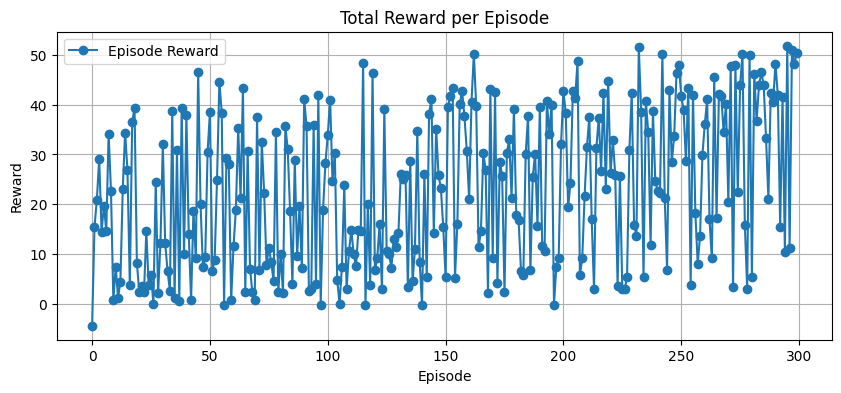

In [38]:
plt.figure(figsize=(10, 4))
plt.plot(episode_rewards, label="Episode Reward", marker='o')
plt.title("Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.show()

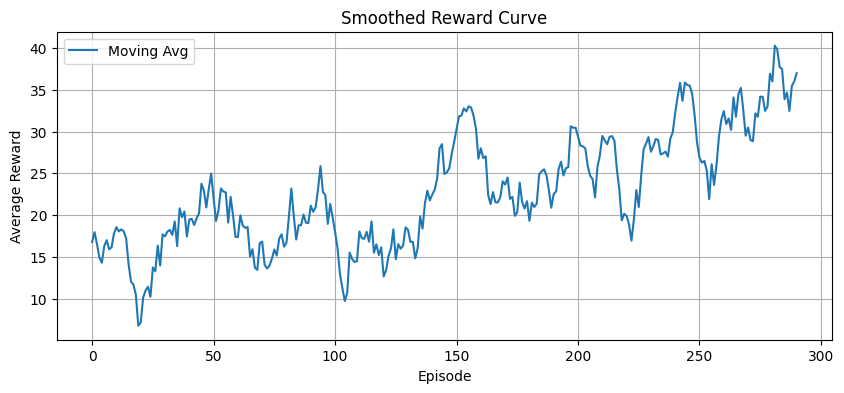

In [39]:
if len(episode_rewards) >= 10:
    def moving_avg(data, window=10):
        return np.convolve(data, np.ones(window)/window, mode='valid')
    plt.figure(figsize=(10, 4))
    plt.plot(moving_avg(episode_rewards), label="Moving Avg")
    plt.title("Smoothed Reward Curve")
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.grid(True)
    plt.legend()
    plt.show()

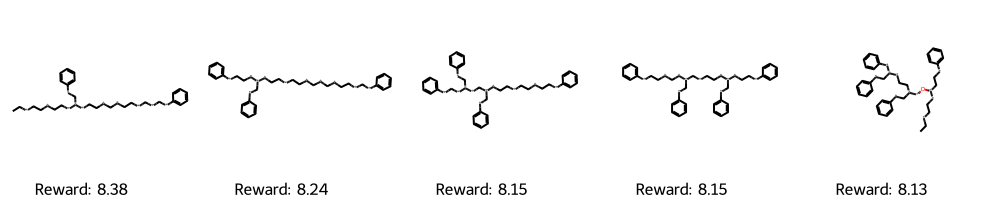

In [40]:
from rdkit.Chem import Descriptors

def check_lipinski(mol):
    mw = Descriptors.MolWt(mol)
    logp = Crippen.MolLogP(mol)
    h_d = Descriptors.NumHDonors(mol)
    h_a = Descriptors.NumHAcceptors(mol)
    return mw <= 500 and logp <= 5 and h_d <= 5 and h_a <= 10

valid_mols = [(r, m) for r, m in top_molecules if m is not None]
if valid_mols:
    mols = [m for _, m in valid_mols]
    legends = [f"Reward: {r:.2f} {'✅' if check_lipinski(m) else '❌'}" for r, m in valid_mols]
    img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200), legends=legends)
    display(img)
else:
    print("⚠️ No valid top molecules to display.")


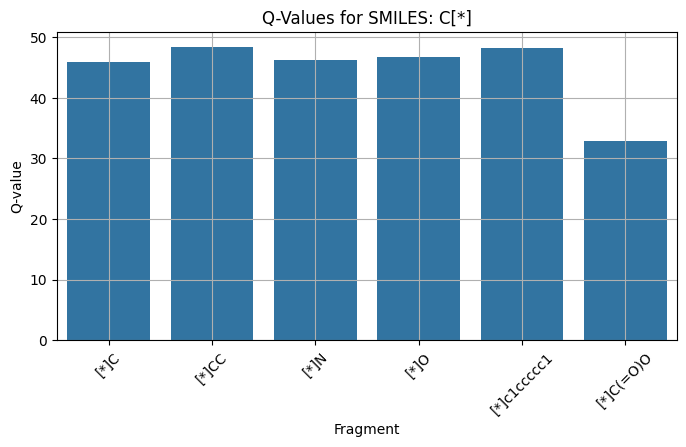

In [41]:
test_smiles = "C[*]"
state_vec = encode_smiles(test_smiles)
state_tensor = torch.tensor(state_vec, dtype=torch.float32).unsqueeze(0)
q_vals = policy_net(state_tensor).detach().numpy().flatten()

plt.figure(figsize=(8, 4))
sns.barplot(x=fragments, y=q_vals)
plt.title(f"Q-Values for SMILES: {test_smiles}")
plt.ylabel("Q-value")
plt.xlabel("Fragment")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [42]:
frames = [Draw.MolToImage(m, size=(200, 200)) for m in animation_smiles if m is not None]
fig, ax = plt.subplots()

def update(frame):
    ax.clear()
    ax.imshow(frame)
    ax.axis("off")

ani = animation.FuncAnimation(fig, update, frames=frames, interval=1000)
plt.close()
HTML(ani.to_jshtml())